In [6]:
import os
import cv2
import imutils
import numpy as np
from glob import glob
from tqdm import tqdm
from pathlib import Path
from typing import List, Tuple
import pywt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from joblib import dump
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (6, 5)

SEED = 0
RAW_ROOT = "."
CLEAN_ROOT = "cleaned"
IMG_SIZE = 64


CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

MAKE_PLOTS = True

def crop_img(img: np.ndarray) -> np.ndarray:
    """
	Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft  = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop   = tuple(c[c[:, :, 1].argmin()][0])
    extBot   = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return new_img

def preprocess_split(src_root: str, dst_root: str, img_size: int = IMG_SIZE):
    """
    Clean both Training and Testing:
      - crop (largest contour)
      - resize to img_size x img_size
      - preserve class subfolders
    """
    for split in ["Training", "Testing"]:
        src_split = Path(src_root) / split
        if not src_split.exists():
            raise FileNotFoundError(f"Missing: {src_split}")

        for cls in CLASSES:
            in_dir = src_split / cls
            out_dir = Path(dst_root) / split / cls
            out_dir.mkdir(parents=True, exist_ok=True)
            paths = sorted(glob(str(in_dir / "*")))
            for p in tqdm(paths, desc=f"Preprocess {split}/{cls}", unit="img"):
                img = cv2.imread(p)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                try:
                    ci = crop_img(img)
                except Exception:
                    ci = img
                ci = cv2.resize(ci, (img_size, img_size))
                out_path = out_dir / Path(p).name
                cv2.imwrite(str(out_path), cv2.cvtColor(ci, cv2.COLOR_RGB2BGR))

In [ ]:
def load_split_images(root: str, split: str) -> Tuple[List[np.ndarray], List[int]]:
    X, y = [], []
    for k, cls in enumerate(CLASSES):
        folder = Path(root) / split / cls
        paths = sorted(glob(str(folder / "*")))
        for p in paths:
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            X.append(img)
            y.append(k)
    return X, y

In [ ]:
def _entropy(x: np.ndarray, bins: int = 32) -> float:
    hist, _ = np.histogram(np.abs(x), bins=bins, density=True)
    p = hist + 1e-12
    return float(-(p * np.log(p)).sum())

def _stats(c: np.ndarray) -> np.ndarray:
    c = c.ravel().astype(np.float32)
    mean = c.mean()
    std = c.std()
    if std < 1e-12:
        return np.array([mean, std, 0.0, 0.0, (c**2).mean(), _entropy(c)], dtype=np.float32)
    z = (c - mean) / (std + 1e-12)
    skew = (z**3).mean()
    kurt = (z**4).mean() - 3.0
    energy = (c**2).mean()
    ent = _entropy(c)
    return np.array([mean, std, skew, kurt, energy, ent], dtype=np.float32)

def wavedec2_feats(img_gray: np.ndarray, wavelet="db4", levels=3) -> np.ndarray:
    coeffs = pywt.wavedec2(img_gray, wavelet=wavelet, level=levels)
    feats = []
    LL = coeffs[0]
    feats.append(_stats(LL))
    for (LH, HL, HH) in coeffs[1:]:
        feats.append(_stats(LH))
        feats.append(_stats(HL))
        feats.append(_stats(HH))
    return np.concatenate(feats, axis=0)

def img_to_feature_dwt(img_rgb: np.ndarray, wavelet="db4", levels=3) -> np.ndarray:
    g = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
    return wavedec2_feats(g, wavelet=wavelet, levels=levels)

def batch_features_dwt(X_imgs: List[np.ndarray], wavelet="db4", levels=3) -> np.ndarray:
    feats = []
    for im in tqdm(X_imgs, desc=f"Extract DWT ({wavelet}, L{levels})", unit="img"):
        feats.append(img_to_feature_dwt(im, wavelet=wavelet, levels=levels))
    return np.vstack(feats)

In [ ]:
from sklearn.model_selection import StratifiedKFold

def stratified_train_val_20(X: np.ndarray, y: np.ndarray, seed: int = 0):
    y = np.array(y)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    tr_idx, va_idx = next(skf.split(X, y))
    return X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

In [ ]:
def make_search(seed: int = 0) -> GridSearchCV:
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("pca", PCA(n_components=0.95, svd_solver="full", random_state=seed)),
        ("svm", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=seed))
    ])
    param_grid = {
        "pca__n_components": [0.90, 0.95, 0.99],
        "svm__C": [1, 3, 10, 30, 100],
        "svm__gamma": ["scale", 1e-3, 3e-3, 1e-2, 3e-2]
    }
    return GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="accuracy",
        cv=5,
        n_jobs=-1,
        refit=True,
        verbose=1
    )

In [ ]:
from sklearn.utils.multiclass import unique_labels

def evaluate_and_plot(model: Pipeline, X: np.ndarray, y: np.ndarray, title_prefix: str, save_prefix: str = None):
    y_pred = model.predict(X)
    print(f"\n{title_prefix} — classification report:")

    labels_present = unique_labels(y, y_pred)
    names_present = [CLASSES[i] for i in labels_present]
    print(classification_report(
        y, y_pred,
        target_names=names_present,
        labels=labels_present,
        digits=4,
        zero_division=0
    ))

    all_labels = list(range(len(CLASSES)))
    cm = confusion_matrix(y, y_pred, labels=all_labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"{title_prefix} — Confusion Matrix")
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_confusion.png", dpi=160)
    if MAKE_PLOTS:
        plt.show()
    else:
        plt.close()

    try:
        proba = model.predict_proba(X)
        for i, name in enumerate(CLASSES):
            y_bin = (np.array(y) == i).astype(int)
            if y_bin.sum() == 0 or y_bin.sum() == len(y_bin):
                continue
            fpr, tpr, _ = roc_curve(y_bin, proba[:, i])
            auc_i = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc_i:.2f})")
        if plt.gca().has_data():
            plt.plot([0,1],[0,1], "k--")
            plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} — ROC (OvR)")
            plt.legend()
            plt.tight_layout()
            if save_prefix:
                plt.savefig(f"{save_prefix}_roc.png", dpi=160)
            if MAKE_PLOTS:
                plt.show()
            else:
                plt.close()
    except Exception:
        pass


In [ ]:
print("=== Preprocessing (crop + resize) ===")
preprocess_split(RAW_ROOT, CLEAN_ROOT, IMG_SIZE)

print("\n=== Loading cleaned splits ===")
X_train_imgs, y_train = load_split_images(CLEAN_ROOT, "Training")
X_test_imgs,  y_test  = load_split_images(CLEAN_ROOT, "Testing")

print("\n=== Extracting features: DWT only ===")
WAVELET = "db4"
LEVELS = 3
X_train = batch_features_dwt(X_train_imgs, wavelet=WAVELET, levels=LEVELS)
X_test  = batch_features_dwt(X_test_imgs,  wavelet=WAVELET, levels=LEVELS)

=== Preprocessing (crop + resize) ===


Preprocess Training/glioma:   0%|          | 0/1321 [00:00<?, ?img/s]

Preprocess Testing/pituitary: 100%|██████████| 300/300 [00:01<00:00, 196.24img/s]



=== Loading cleaned splits ===

=== Extracting features: DWT only ===


Extract DWT (db4, L3): 100%|██████████| 1311/1311 [00:06<00:00, 217.16img/s]



=== Grid search (PCA + SVM) ===
Fitting 5 folds for each of 75 candidates, totalling 375 fits

Best params: {'pca__n_components': 0.99, 'svm__C': 10, 'svm__gamma': 'scale'}
Val accuracy (best_estimator_): 0.8188976377952756

=== EVAL: Validation subset ===

Validation — classification report:
              precision    recall  f1-score   support

      glioma     0.9579    0.9434    0.9506       265
  meningioma     0.9513    0.9513    0.9513       267
     notumor     1.0000    1.0000    1.0000       319
   pituitary     0.9662    0.9795    0.9728       292

    accuracy                         0.9703      1143
   macro avg     0.9688    0.9685    0.9687      1143
weighted avg     0.9702    0.9703    0.9702      1143



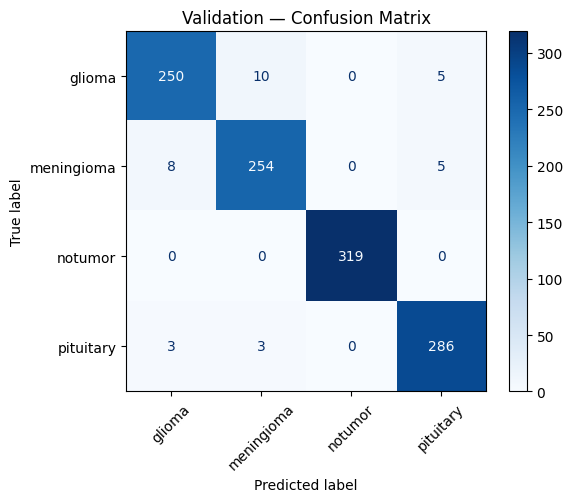

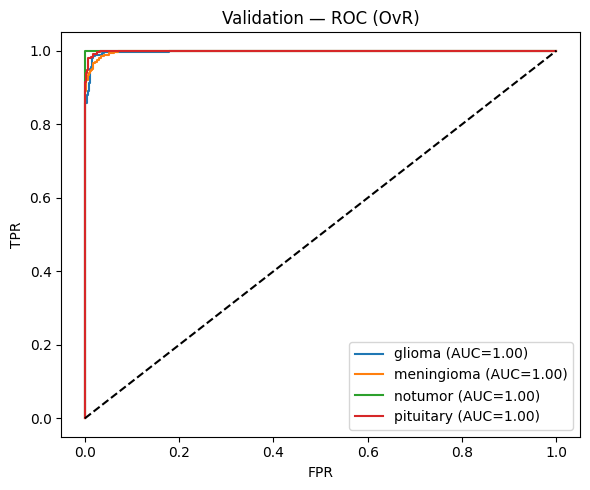


=== EVAL: Held-out Test folder ===

Test — classification report:
              precision    recall  f1-score   support

      glioma     0.7638    0.6900    0.7250       300
  meningioma     0.7380    0.8007    0.7680       306
     notumor     0.9732    0.9852    0.9791       405
   pituitary     0.8490    0.8433    0.8462       300

    accuracy                         0.8421      1311
   macro avg     0.8310    0.8298    0.8296      1311
weighted avg     0.8420    0.8421    0.8413      1311



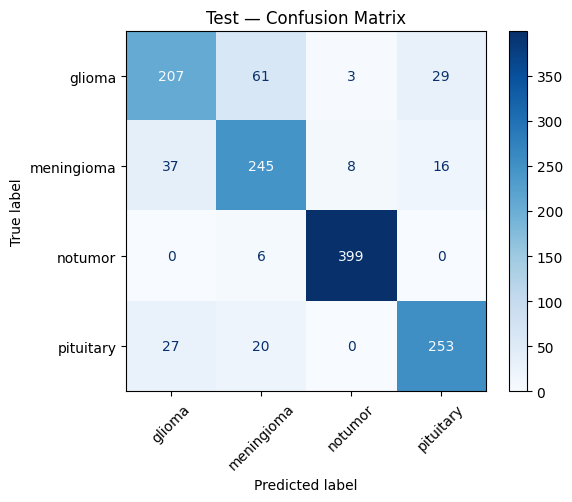

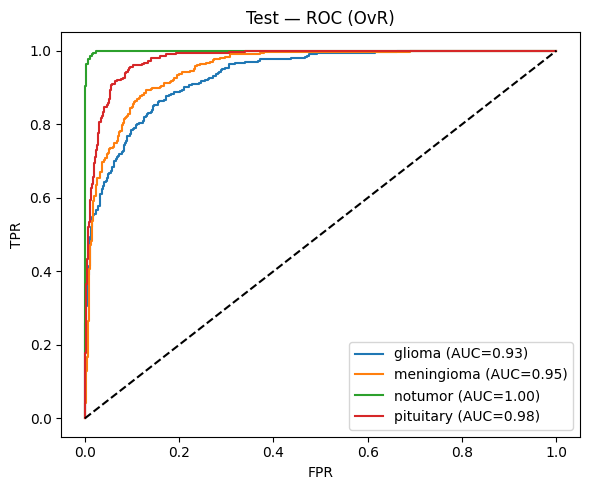


Saved model → artifacts/svm_dwt_pca.joblib


In [ ]:
X_tr, X_va, y_tr, y_va = stratified_train_val_20(X_train, y_train, seed=SEED)

print("\n=== Grid search (PCA + SVM) ===")
search = make_search(seed=SEED)
search.fit(X_tr, y_tr)
print("\nBest params:", search.best_params_)
print("Val accuracy (best_estimator_):", search.score(X_va, y_va))

best_model = search.best_estimator_
best_model.fit(X_train, y_train)

print("\n=== EVAL: Validation subset ===")
evaluate_and_plot(best_model, X_va, y_va, "Validation", save_prefix="val_dwt")

print("\n=== EVAL: Held-out Test folder ===")
evaluate_and_plot(best_model, X_test, y_test, "Test", save_prefix="test_dwt")

Path("artifacts").mkdir(exist_ok=True)
dump(best_model, "artifacts/svm_dwt_pca.joblib")
print("\nSaved model → artifacts/svm_dwt_pca.joblib")